# Demo for launching an experiment set  

*Objectif*: **Comparing baseline models with RAG metrics (use the _retriever_context_)**

In [2]:
import os
import sys
import time

import dotenv
from IPython.display import HTML
import numpy as np
import pandas as pd
import requests

dotenv.load_dotenv("../.env")
sys.path.append("..")
from eg1.utils import log_and_raise_for_status

#EG1_API_URL = "http://localhost:8000/v1"
EG1_API_URL = "https://eg1.dev.etalab.gouv.fr/v1"
EG1_API_KEY = os.getenv("EG1_API_KEY") 
ALBERT_API_URL = "https://albert.api.staging.etalab.gouv.fr/v1"
ALBERT_API_KEY = os.getenv("ALBERT_API_KEY")
MFS_API_URL = "https://franceservices.etalab.gouv.fr/api/v1"
MFS_API_KEY = os.getenv("MFS_API_KEY")
headers = {"Authorization": f"Bearer {EG1_API_KEY}"}

In [3]:
# Various utility functions
# --
def format_metrics(row):
   # format a dataframe has a series of "mean ± std"
   metrics = {}
   for metric in final_df.columns.levels[0]:
       mean_value = row[(metric, 'mean')]
       std_value = row[(metric, 'std')]
       metrics[metric] = f"{mean_value:.2f} ± {std_value:.2f}"
   return pd.Series(metrics)
    
def highlight_cells(s):
 # Custom function to highlight the entry with the highest/lowest mean value
    means = s.apply(lambda x: float(x.split('±')[0].strip()))
    # Create a mask where 1 for max, 0 for min
    max_mean_index = means.idxmax()
    min_mean_index = means.idxmin()  
    mask = pd.Series({max_mean_index: 1, min_mean_index: 0}, index=s.index)
    return [
        'font-weight: bold; color: salmon' if mask_value == 0 else
        'font-weight: bold; color: green' if mask_value == 1 else
        ''
        for mask_value in mask
    ]

## Designing and running an experiment set

In [19]:
# Designing my experiments
# --
expset_name = "mfs_RAG_metrics_v3"
expset_readme = "Evaluation of baseline models with RAG metrics (retriever_context)."
metrics = ["contextual_relevancy", "contextual_recall", "contextual_precision", "ragas"]
common_params = {
    "dataset" : "MFS_questions_v01",
    "model": {
        "extra_params": {"rag": {"mode":"rag", "limit":7}},
        "sampling_params" : {"temperature": 0.2}
    },
    "metrics" : metrics,
    "judge_model": "gpt-4o",
}
grid_params = {
    "model": [
        {
          "name": "meta-llama/Llama-3.2-3B-Instruct", 
          "base_url": MFS_API_URL, "api_key": MFS_API_KEY, 
        },
        {
          "name": "google/gemma-2-9b-it", 
          "base_url": MFS_API_URL, "api_key": MFS_API_KEY, 
        },
        {
          "name": "meta-llama/Llama-3.1-8B-Instruct", 
          "base_url": MFS_API_URL, "api_key": MFS_API_KEY, 
        },
        {
          "name": "AgentPublic/llama3-instruct-guillaumetell", 
          "base_url": MFS_API_URL, "api_key": MFS_API_KEY, 
        }
    ],
}

# Lauching the experiment set
expset = {
    "name" : expset_name, 
    "readme": expset_readme,
    "cv": {"common_params": common_params, "grid_params": grid_params, "repeat":3}
}
response = requests.post(f'{EG1_API_URL}/experiment_set', json=expset, headers=headers)
resp = response.json()
if "id" in resp:
    expset_id = resp["id"]
    print(f'Created expset: {resp["name"]} ({resp["id"]})')
else:
    print(resp)

Created expset: mfs_RAG_metrics_v3 (18)


## Reading and showing results

-> Show the mean and std score, for each metrics, across the experiment repetition. The std show the variability of the model.

In [8]:
# Read results
# --
df_all = None # multi-dimensional DataFrame
arr_all = {} # keep references of source array per metric metrics 

# Fetch results and compute macro metrics (mean, std etc).
# --
response = requests.get(f'{EG1_API_URL}/experiment_set/{expset_id}', headers=headers)
expset = response.json()
rows = []
for i, exp in enumerate(expset["experiments"]):
    # Get an experiment result
    exp_id = exp["id"]
    response = requests.get(f'{EG1_API_URL}/experiment/{exp_id}?with_results=true', headers=headers)
    experiment = response.json()
    # experiment["name"] # Name of the experiment
    if experiment["experiment_status"] != "finished":
        print(f"Warning: experiment {exp_id} is not finished yet...")
    results = experiment["results"]
    model = experiment["model"]["name"]
    if experiment["model"].get("extra_params"):
        if experiment["model"]["extra_params"].get("rag") :
            model = experiment["model"]['name'] + "--rag"
    
    # Add an observation row from the observation_table (mean, std etc)
    row = {"model": model}
    rows.append(row)
    metric_arrs = {}
    arr_all[model] = metric_arrs
    for metric_results in results: 
        metric = metric_results["metric_name"]
        arr = np.array([x["score"] for x in metric_results["observation_table"] if pd.notna(x["score"])])
        row[(metric, 'mean')] = np.mean(arr)
        row[(metric, 'std')] = np.std(arr)
        row[(metric, 'median')] = np.median(arr)
        row[(metric, 'mean_std')] = f"{arr.mean():.2f} ± {arr.std():.2f}"  # Formatting as 'mean±std'
        row[(metric, 'support')] = len(arr)
        metric_arrs[metric] = arr
    
df_all = pd.DataFrame(rows)
df_all.set_index('model', inplace=True)
df_all.columns = pd.MultiIndex.from_tuples(df_all.columns)
final_df = df_all.xs('mean', axis=1, level=1) # pick the "macro" metric to show (mean, std, support etc)

# Group and average the result of the experiments by models
# --
final_df = final_df.groupby(level=0).agg(['mean', 'std'])  # groupby "model"
final_df.index.name = None
final_df = final_df.apply(format_metrics, axis=1) # final formating

#final_df = final_df.reindex([m["name"] for m in grid_params["model"]]) # reorder rows
final_df = final_df.sort_values(by='contextual_relevancy', ascending=False)
final_df = final_df[metrics] # reorder columns
final_df = final_df.style.apply(highlight_cells, axis=0)
final_df

/home/dtrckd/.local/lib/python3.13/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dtrckd/.local/lib/python3.13/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dtrckd/.local/lib/python3.13/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dtrckd/.local/lib/python3.13/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dtrckd/.local/lib/python3.13/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_3588159/1038787028.py:36: RuntimeWarning: Mean of empty slice.
  row[(metric, 'mean_std')] = f"{arr.

,contextual_relevancy,contextual_recall,contextual_precision,ragas
meta-llama/Llama-3.2-3B-Instruct--rag,nan ± nan,nan ± nan,nan ± nan,nan ± nan
google/gemma-2-9b-it--rag,0.42 ± 0.02,0.73 ± 0.03,0.51 ± 0.03,0.50 ± 0.05
AgentPublic/llama3-instruct-guillaumetell--rag,0.41 ± 0.01,0.71 ± 0.01,0.56 ± 0.01,0.62 ± 0.04
meta-llama/Llama-3.1-8B-Instruct--rag,0.41 ± 0.01,0.74 ± 0.03,0.55 ± 0.03,0.42 ± 0.05


In [ ]:
# Patching the experiment set
grid_params = {
    "model": [
        {
          "name": "meta-llama/Llama-3.3-70B-Instruct", 
          "base_url": MFS_API_URL, "api_key": MFS_API_KEY, 
        },
        {
         "name": "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B",
          "base_url": MFS_API_URL, "api_key": MFS_API_KEY, 
        },
    ],
}
expset = {
    "cv": {"common_params": common_params, "grid_params": grid_params, "repeat":3}
}
response = requests.patch(f'{EG1_API_URL}/experiment_set/{expset_id}', json=expset, headers=headers)
resp = response.json()
if "id" in resp:
    expset_id = resp["id"]
    print(f'Created expset: {resp["name"]} ({resp["id"]})')
else:
    print(resp)

# Visualize the score dispersion for each metrics.

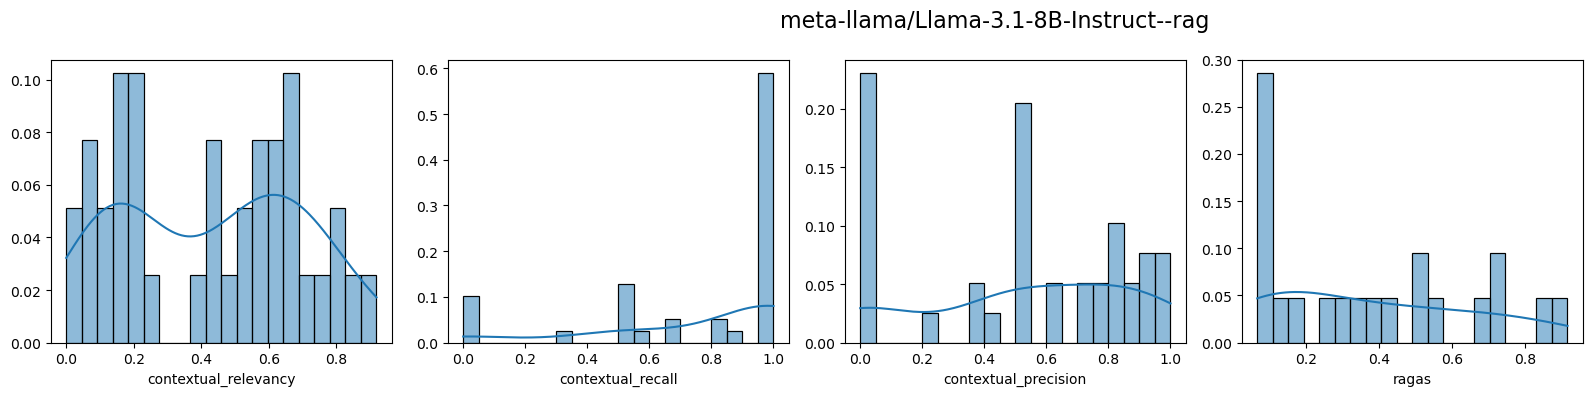

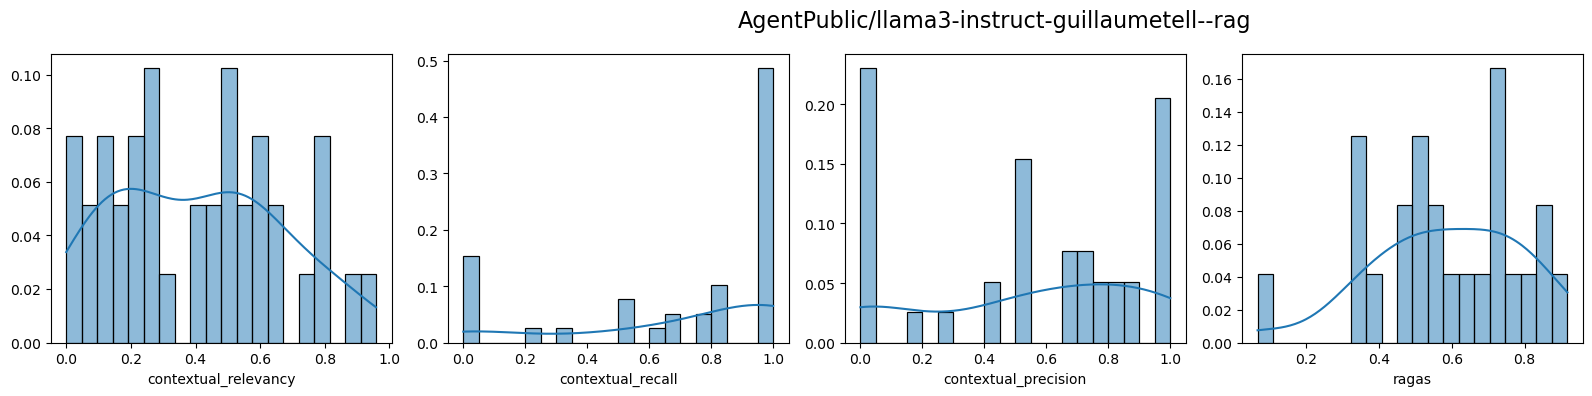

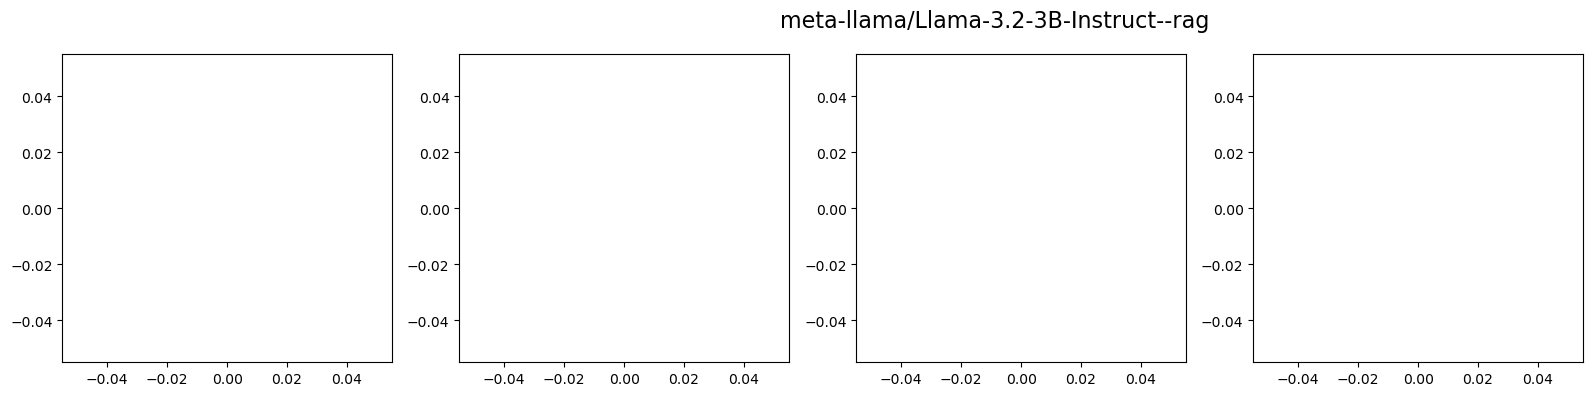

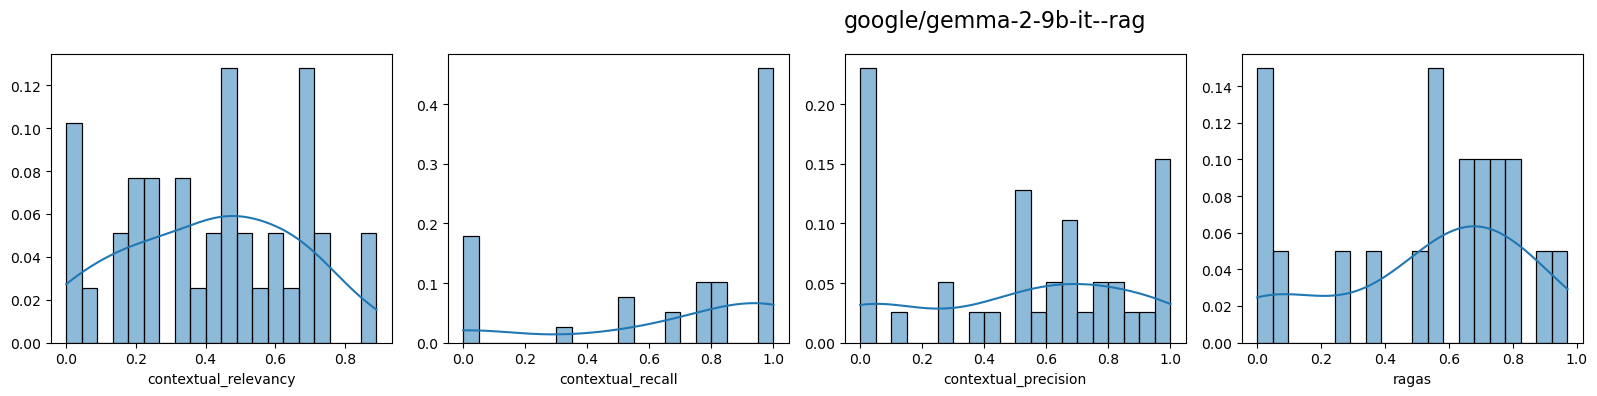

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

for model, metrics_arr in arr_all.items():
    experiment_title = model
    metrics_arr = {k:metrics_arr[k] for k in metrics} # reorder metrics
    # Pad missing value with np.nan
    arrays = list(metrics_arr.values())
    max_length = max(len(arr) for arr in arrays)
    arr_metrics = np.array([np.pad(arr, (0, max_length - len(arr)), constant_values=np.nan) for arr in arrays])
    df = pd.DataFrame(arr_metrics.T, columns=metrics_arr.keys())
    
    num_cols = 5
    num_plots = len(df.columns)
    num_rows = (num_plots + num_cols - 1) // num_cols  
    plt.figure(figsize=(num_cols * 4, num_rows * 4))
    for i, column in enumerate(df.columns, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.histplot(df[column], bins=20, stat="probability", element="bars", kde=True)
        plt.ylabel("") 
    
    plt.suptitle(experiment_title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [24]:
# RETRY failed experiment !
# --
response = requests.post(f'{EG1_API_URL}/retry/experiment_set/{expset_id}', headers=headers)
response.json()

{'experiment_ids': [], 'result_ids': [738]}

In [33]:
# Force Rerun observations/metrics
# --
response = requests.patch(f'{EG1_API_URL}/experiment/150?with_results=true', headers=headers, json={"metrics":metrics, "rerun_metrics":True})
response.json()

{'name': 'mfs_RAG_metrics_v1__2',
 'readme': None,
 'experiment_set_id': 8,
 'judge_model': 'gpt-4o',
 'id': 150,
 'created_at': '2024-12-15T14:41:26.024831',
 'experiment_status': 'running_metrics',
 'num_try': 39,
 'num_success': 39,
 'dataset': {'name': 'MFS_questions_v01',
  'readme': 'nr',
  'id': 1,
  'created_at': '2024-12-15T00:33:29.392837',
  'has_query': True,
  'has_output': False,
  'has_output_true': True,
  'size': 39,
  'columns': ['query', 'output_true', 'top_valid', 'operateur', 'thematique']},
 'model': {'name': 'AgentPublic/llama3-instruct-8b',
  'base_url': 'https://franceservices.etalab.gouv.fr/api/v1',
  'system_prompt': None,
  'sampling_params': {'temperature': 0.2},
  'extra_params': {'rag': {'mode': 'rag', 'limit': 7}},
  'id': 150}}